In [25]:
# Imports

import pandas as pd
import os
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import tensorflow as tf

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans

from datetime import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.losses import Loss
from keras.callbacks import EarlyStopping

In [ ]:
# INPUT PARAMETERS

folder_path = r'E:\SMART GRID FOR EV\SAME_METERS\TEST_N2_100'   # Specify the folder where your CSV files are located

output_folder = r"E:\SMART GRID FOR EV\RESULTS\TRANS_RESULTS"   # Output foler path to save results

trained_meters = 60
split_size = 0.80
time_step =  60
EVALUATION_INTERVAL = 200
EPOCHS = 60

L1 = 30
L2 = 30
L3 = 30
L4 = 30

LD1 = 1
Patience = 3

BATCH_SIZE = 256
BUFFER_SIZE = 10000

#scaler = StandardScaler()                                    # Scale of the output and input inthe range -1 to 1 to match the scale of the layer of LSTM
# Below used Normalize to check!!!
scaler = MinMaxScaler(feature_range = (0,1))                # scale of the output and input inthe range 0-1 to match the scale of the layer of LSTM



In [27]:
# Function to Extract data from csv to Dataframe

def excel_to_df(url):

    match = re.search(r'(\d+)_merged\.csv', url)                    # Extracting meter number from CSV name
    meter_number = match.group(1)
    dataframe = pd.read_csv(url)
    
    df_daily = dataframe.copy()                                                 # Copying main dataframe to create daily consumption data frame
    df_daily['Meter_reading'] =  df_daily.iloc[:, 2:26].sum(axis=1)       # Adding up 24 hours datapoint values
    df_daily = df_daily.drop(df_daily.iloc[:, 1:26],axis=1)                     # Dropping hourly columns after adding

    if (df_daily['Meter_reading'] == 0).any():  # Check if any value in 'Meter_reading' column is zero
        return None, meter_number  # If zero value exists, return None for dataframe

    return df_daily, meter_number



In [28]:
# Normalising and dividing data into Train, Val and test

def data_splitting_shapping(dataset):
    
    if isinstance(dataset, pd.Series):
        target_dataset = dataset #For Transfer learning
    else:
        target_dataset = dataset["Meter_reading"] #For meter prediction

    # Standardize the data before model fitting as it will boost the performance( in neural networks)
    target_dataset = scaler.fit_transform(np.array(target_dataset).reshape(-1,1))       # reshape: convert the univariate 1D array into 2D
    
    train_size = int(len(target_dataset)*split_size)
    test_size = len(target_dataset)- train_size
    val_size = int(train_size*0.20)
    
    train_data = target_dataset[0:train_size-val_size, : ]                # Splitting data into train test Val
    test_data = target_dataset[train_size:len(target_dataset), :1 ]
    val_data = target_dataset[len(target_dataset)-test_size-val_size:len(target_dataset)-test_size, :1 ]

    def create_dataset(dataset, time_step = 1):                 # Function to create X and Y nparray from dataset and timestep for LSTM model
        dataX, dataY = [] , []
        for i in range(len(dataset)-time_step-1):
            a = dataset[i:(i+time_step),0]
            dataX.append(a)
            dataY.append(dataset[i + time_step,0])
        return np.array(dataX), np.array(dataY)
    
    X_train, y_train = create_dataset(train_data, time_step)
    X_test, y_test = create_dataset(test_data, time_step)
    X_val, y_val = create_dataset(val_data, time_step)

    X_train = X_train.reshape(X_train.shape[0],X_train.shape[1], 1)         # Reshaping arrays according LSTM model
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],1)
    X_val = X_val.reshape(X_val.shape[0], X_val.shape[1],1)

    train_univariate = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

    val_univariate = tf.data.Dataset.from_tensor_slices((X_val, y_val))
    val_univariate = val_univariate.batch(BATCH_SIZE).repeat()
    
    return X_train, X_test, X_val, y_train, y_test, y_val, train_univariate, val_univariate

In [29]:
# TRANSFER LEARNING LSTM Architecture

def lstm_archi(X_train, y_train, X_val, y_val, train_univariate, val_univariate):
    
    early_stopping = EarlyStopping(monitor = 'loss', patience=3)                 # Define the early stopping callback

    tf.keras.backend.clear_session()
    
    simple_lstm_model = Sequential()
    
    simple_lstm_model.add(LSTM(units=L1, return_sequences= True, input_shape=(time_step, 1)))      # Model Architecture
    simple_lstm_model.add(Dropout(0.2))

    simple_lstm_model.add(LSTM(units=L2, return_sequences= True))
    simple_lstm_model.add(Dropout(0.2))

    #simple_lstm_model.add(LSTM(units=L3, return_sequences= True))
    #simple_lstm_model.add(Dropout(0.2))

    simple_lstm_model.add(LSTM(units=L4))
    
    simple_lstm_model.add(Dense(units = LD1))

    #simple_lstm_model.compile(optimizer='adam', loss='mae', metrics=['accuracy'])
    simple_lstm_model.compile(optimizer='adam', loss='mae', metrics=['mae'])

    history = simple_lstm_model.fit(train_univariate, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL, 
                                    validation_data=val_univariate, validation_steps=30,
                                    callbacks=[early_stopping], verbose=0,batch_size = 20)

    return simple_lstm_model, history

In [30]:
# Plotting Model loss

def loss_graph(history, dataset):
    plt.figure(figsize=(10, 5))

    # Plot model loss on the left side and accuaracy on right
    #plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    #plt.subplot(1, 2, 2)
    #plt.plot(history.history['accuracy'])
    #plt.plot(history.history['val_accuracy'])
    #plt.title('Model Accuracy')
    #plt.ylabel('Accuracy')
    #plt.xlabel('Epoch')
    #plt.legend(['Train', 'Validation'], loc='upper right')   

    #plt.tight_layout()                                                  # Ensure proper spacing between subplots
    plt.show()


In [53]:
# Plotting graph call

def plot_graphs(Meter_number, dataset, actual_test, base_prediction, median_prediction, min_prediction, max_prediction, predictions):
    

    plt.figure(figsize=(15, 8))
    #for i, prediction in enumerate(predictions):
        #prediction =scaler.inverse_transform(prediction)
        #plt.plot(prediction, label=f'Model {i+1} Prediction')

    plt.plot(base_prediction, label='Mean Prediction', linewidth=2, linestyle='--')
    plt.plot(median_prediction, label='Median Prediction', linewidth=2, linestyle='--')
    plt.plot(actual_test, label='Actual Values', linewidth=2, linestyle='--')

    #plt.fill_between(range(len(base_prediction)), min_prediction, max_prediction, color='blue', alpha=0.2) # Shaded region for range
    plt.fill_between(range(len(base_prediction)), min_prediction.flatten(), max_prediction.flatten(), color='blue', alpha=0.2) # Shaded region for range

    plt.xlabel('Data Point Index')
    plt.ylabel('Predicted Value')
    plt.title('Actuals vs. Test Predictions from Cluster Models (Meter: {})'.format(Meter_number))
    plt.legend()
    plt.grid(True)
    plt.show()


    #Plot_Energy_Distribution

    #sns.distplot(dataset["Meter_reading"])
    #plt.title('Energy Distribution')


In [47]:
# Model evaluation to find MAE, MAPE, RMSE

def model_eval( base_prediction, X_test, y_test):

   # Predicting consumption using test data

    test_predictions = base_prediction

    y_test = y_test.reshape(y_test.shape[0], 1)

    actual_test = scaler.inverse_transform(y_test)

    # A lower RMSE, MAE, and MAPE for your model compared to the baseline indicate that your model is performing better.
    
    # Calculate MAE (Mean Absolute error)
    mae_test = np.mean(np.abs(test_predictions - actual_test))


    # Calculate MAPE (Mean Absolute Percentage Error)
    denominator = np.where(actual_test != 0, actual_test, 1)
    mape_test = np.mean(np.abs((actual_test - test_predictions) / denominator)) * 100


    # Calculate RMSE (Root Mean Squared Error)
    rmse_test = np.sqrt(np.mean((test_predictions - actual_test) ** 2))

    return mae_test, mape_test, rmse_test, actual_test

In [54]:
# Results to Excel

def results_OP(Results, output_folder):
    # create a DataFrame from the results
    Results_df = pd.DataFrame(Results, columns=['Meter_number', 'Mean_MAE', 'Mean_MAPE', 'Mean_RMSE','Median_MAE', 'Median_MAPE', 'Median_RMSE', 'Time step'])

    current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_excel = os.path.join(output_folder, 'Results_L1_{}_timestep_{}_{}.xlsx'.format(L1, time_step, current_time))

    Results_df.to_excel(output_excel, index=False)                  # Save the DataFrame to a CSV file

    if os.path.exists(output_excel):
        print(f"CSV file saved to {output_excel}")
    else:
        print("Error: CSV file not saved.")


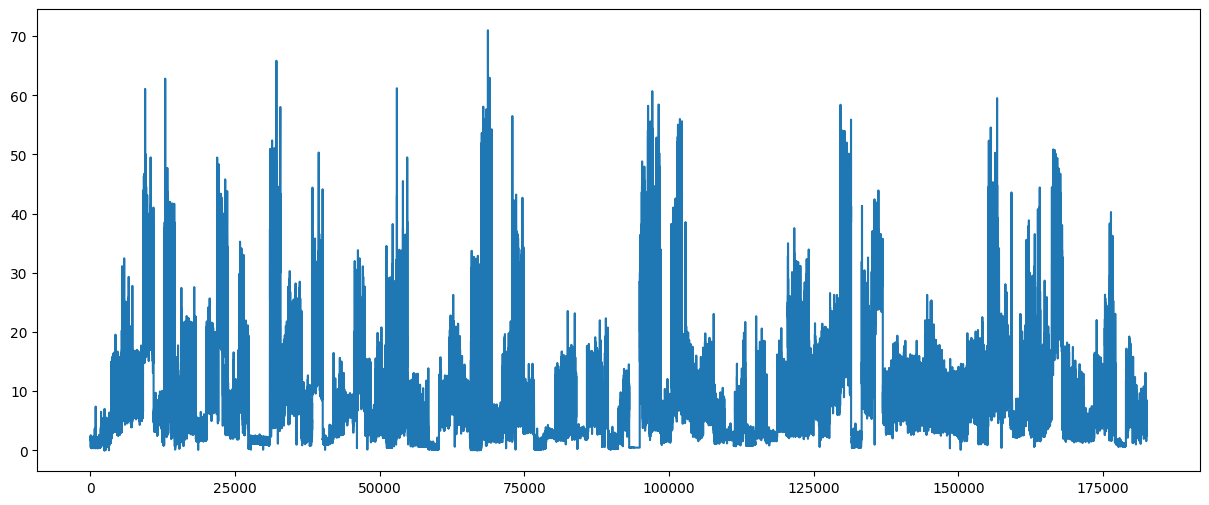

In [34]:
# Creating the combined_dataset from multiple daily df's

data_frames = []

for filename in os.listdir(folder_path):                        #Loop through the files in the folder
    if filename.endswith(".csv"):                           
        file_path = os.path.join(folder_path, filename)

        df_daily, Meter_number = excel_to_df(file_path)

        if df_daily is None:                                    # Skipping the meter with zero daily energy consumption
            continue                                            # Skip to the next CSV file

        newdataset = df_daily['Meter_reading']                  # Creating a combined dataset for pre training
        data_frames.append(newdataset)
        combined_dataset = pd.concat(data_frames, axis=0)       # 0 for y axis/ 1 for x axis

combined_df = combined_dataset.to_frame()
       
plt.figure(figsize=(15, 6))
plt.plot(combined_dataset.values)
plt.show()

#Elbow Method

#Standardize the data

combined_dataset_array = combined_dataset.values.reshape(-1, 1)

#Below use scaler for standarization
data_scaled = scaler.fit_transform(combined_dataset_array)

#Determine the optimal number of clusters using the Elbow Method

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(data_scaled)
    wcss.append(kmeans.inertia_)

#Plot the Elbow Method graph

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.show()

c:\Users\Sairaj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


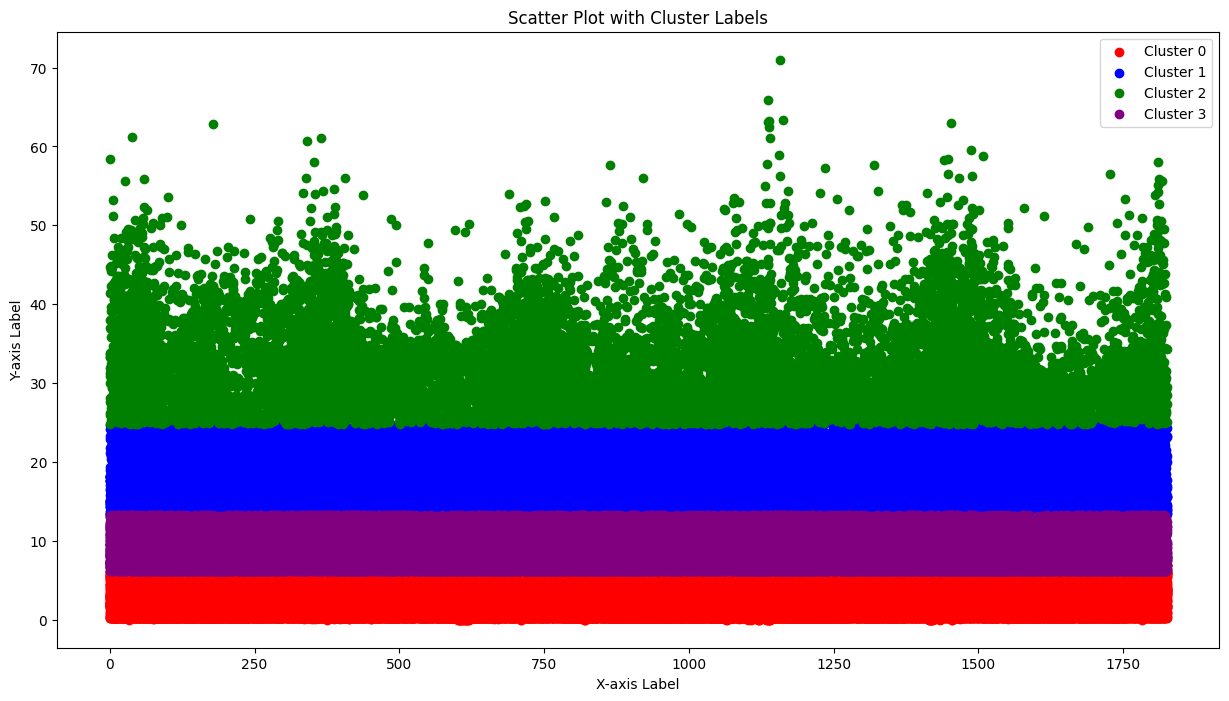

In [35]:
# Clustering the data and plotting a scatter plot

num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(combined_df)                                 # Fit KMeans to your data
cluster_labels = kmeans.labels_                         # Get cluster labels
combined_df['cluster_label'] = cluster_labels           # Add cluster labels to the DataFrame

plt.figure(figsize=(15, 8))                             # Plot scatter plot with cluster labels

colors = ['red', 'blue', 'green', 'purple','yellow','pink']

for cluster_num in range(num_clusters):
    cluster_data = combined_df[combined_df['cluster_label'] == cluster_num]
    plt.scatter(cluster_data.index, cluster_data['Meter_reading'], color=colors[cluster_num], label=f'Cluster {cluster_num}')

plt.title('Scatter Plot with Cluster Labels')
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.legend()
plt.show()

In [36]:
# Counting number of values in each clusters

unique_labels, counts = np.unique(cluster_labels, return_counts=True)       # Count the occurrences of each unique cluster label
cluster_counts = dict(zip(unique_labels, counts))                           # Create a dictionary to store the cluster label counts

for cluster_label, count in cluster_counts.items():                         # Print the number of values in each cluster
    print(f"Cluster {cluster_label}: {count} values")


Cluster 0: 81246 values
Cluster 1: 24330 values
Cluster 2: 13925 values
Cluster 3: 63099 values


 
Cluster =  0
 


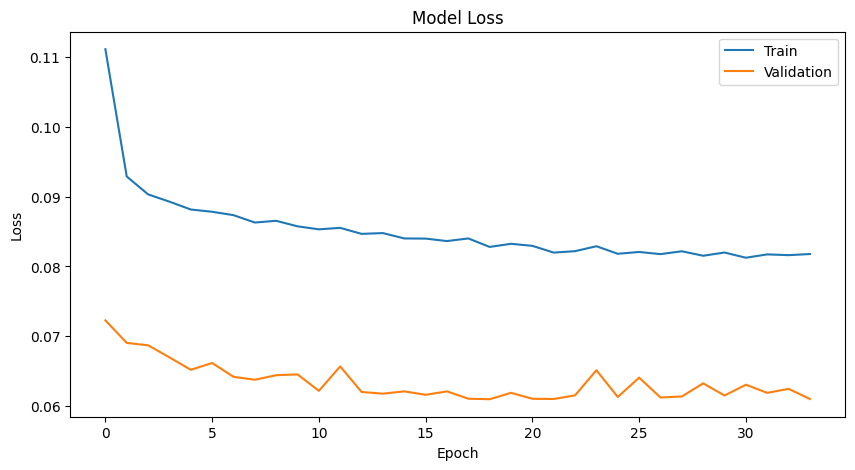

 
Cluster =  1
 


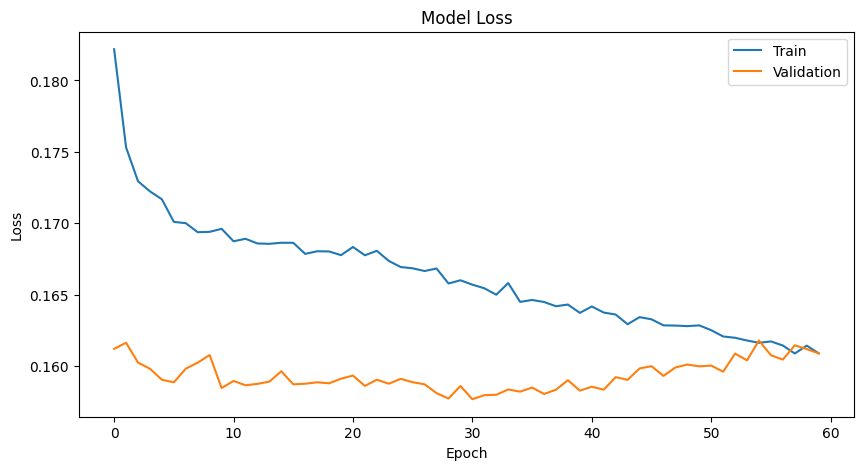

 
Cluster =  2
 


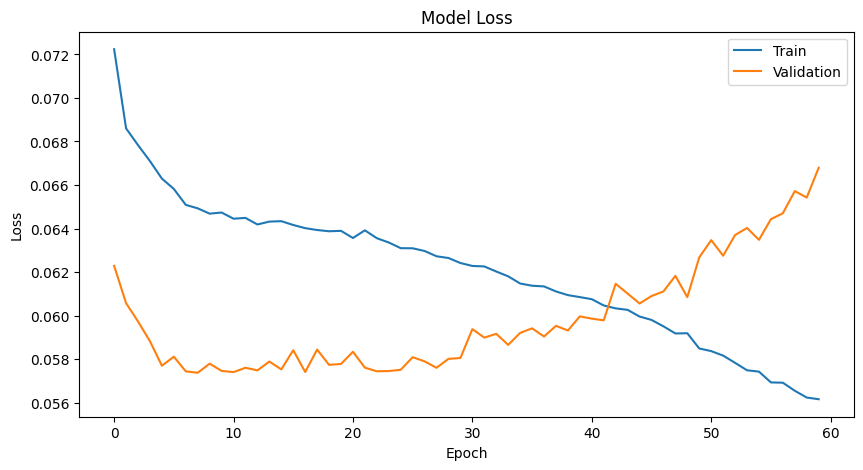

 
Cluster =  3
 


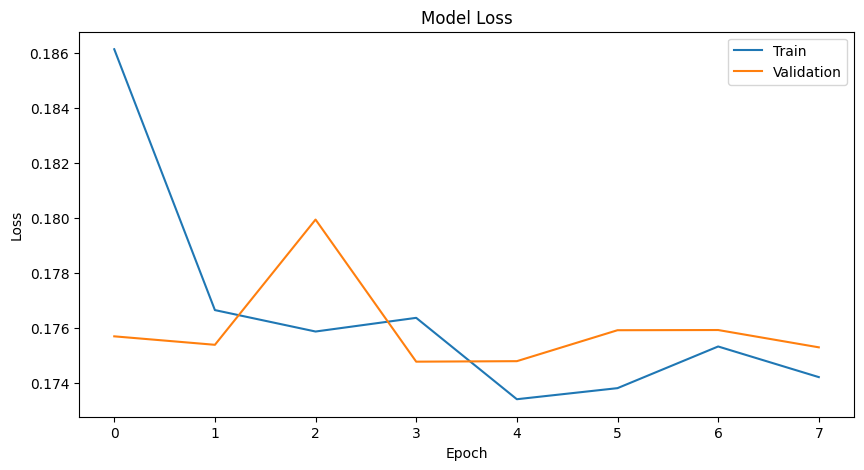

In [37]:
# Assuming combined_dataset and scaled_data are defined appropriately
# combined_df is obtained from the previous code snippet

# Assuming combined_df has the 'cluster_label' column containing the cluster labels
clusters = combined_df['cluster_label'].values

# Initialize a list to store individual cluster models
cluster_models = []

# Train separate LSTM models for each cluster
for cluster_label in np.unique(clusters):
    cluster_data = combined_df[clusters == cluster_label]   # It selects only those rows from scaled_data where the corresponding value in clusters matches cluster_label.
    
    X_train, X_test, X_val, y_train, y_test, y_val, train_univariate, val_univariate = data_splitting_shapping(cluster_data)

    simple_lstm_model, history = lstm_archi(X_train, y_train, X_val, y_val, train_univariate, val_univariate)

    print(" ")
    print("Cluster = ", cluster_label)
    print("=================================")
    print(" ")
    
    loss_graph(history, combined_dataset)

    cluster_models.append(simple_lstm_model)                # Add the trained model to the list of cluster models


In [55]:
#  Base model function to combine all cluster-trained models

def base_model_predict(input_data):
    predictions = []
    for model in cluster_models:
        prediction = model.predict(input_data)
        predictions.append(prediction)


    base_prediction = np.mean(predictions, axis=0)              # Averaging predictions from all cluster models 
    median_prediction = np.median(predictions, axis=0)          # TAking median from all cluster models
    min_prediction = np.min(predictions, axis=0)                # Finding minimum from all cluster models
    max_prediction = np.max(predictions, axis=0)                # Finding maximum from all cluster models

    base_prediction =scaler.inverse_transform(base_prediction)
    median_prediction =scaler.inverse_transform(median_prediction)
    min_prediction = scaler.inverse_transform(min_prediction)
    max_prediction = scaler.inverse_transform(max_prediction)

    return base_prediction, median_prediction, min_prediction, max_prediction, predictions



10/10 [==============================] - 0s 18ms/step
Results of meter:-  102489
Mean_Predictions
MAE: 2.807415862099069
MAPE: 35.98461080294627
RMSE: 3.8105136838962888
 
Median_Predictions
MAE: 2.7971597847235006
MAPE: 35.85868045852333
RMSE: 3.819360646254021


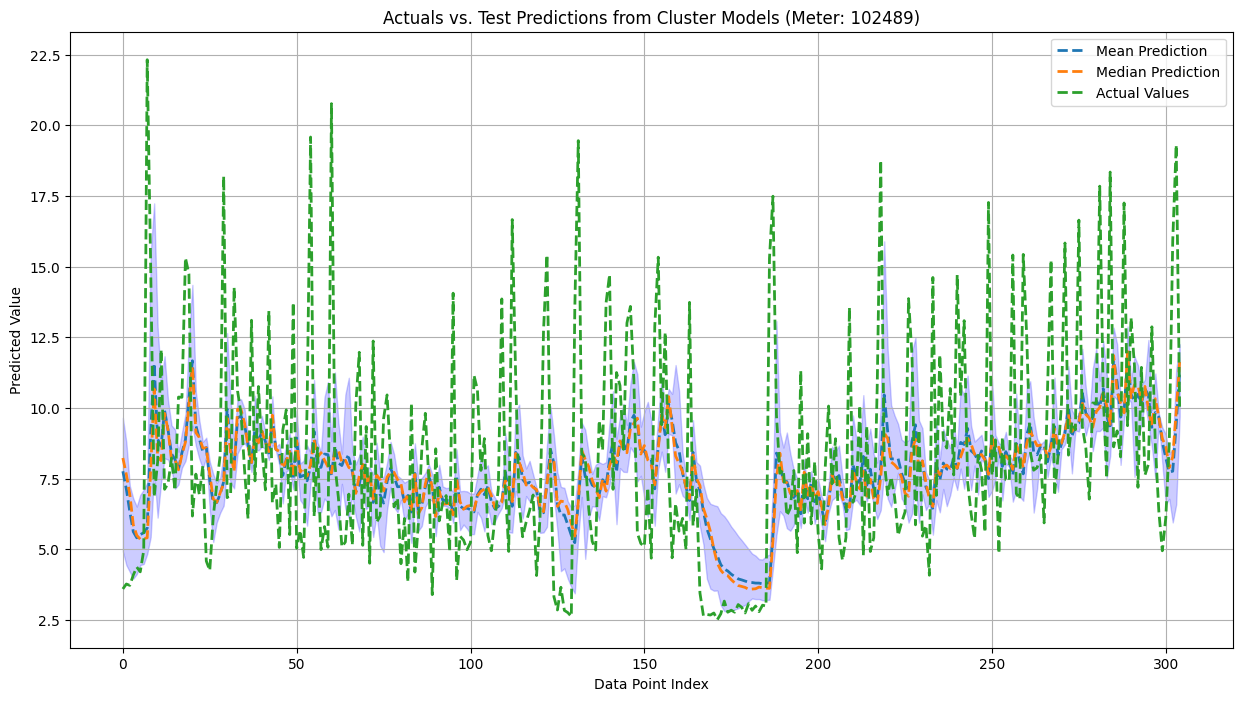

10/10 [==============================] - 0s 17ms/step
Results of meter:-  111673
Mean_Predictions
MAE: 1.7752231207300406
MAPE: 20.41221680678897
RMSE: 2.2588219549579427
 
Median_Predictions
MAE: 1.7477827397205792
MAPE: 20.491527706508233
RMSE: 2.1969949127099855


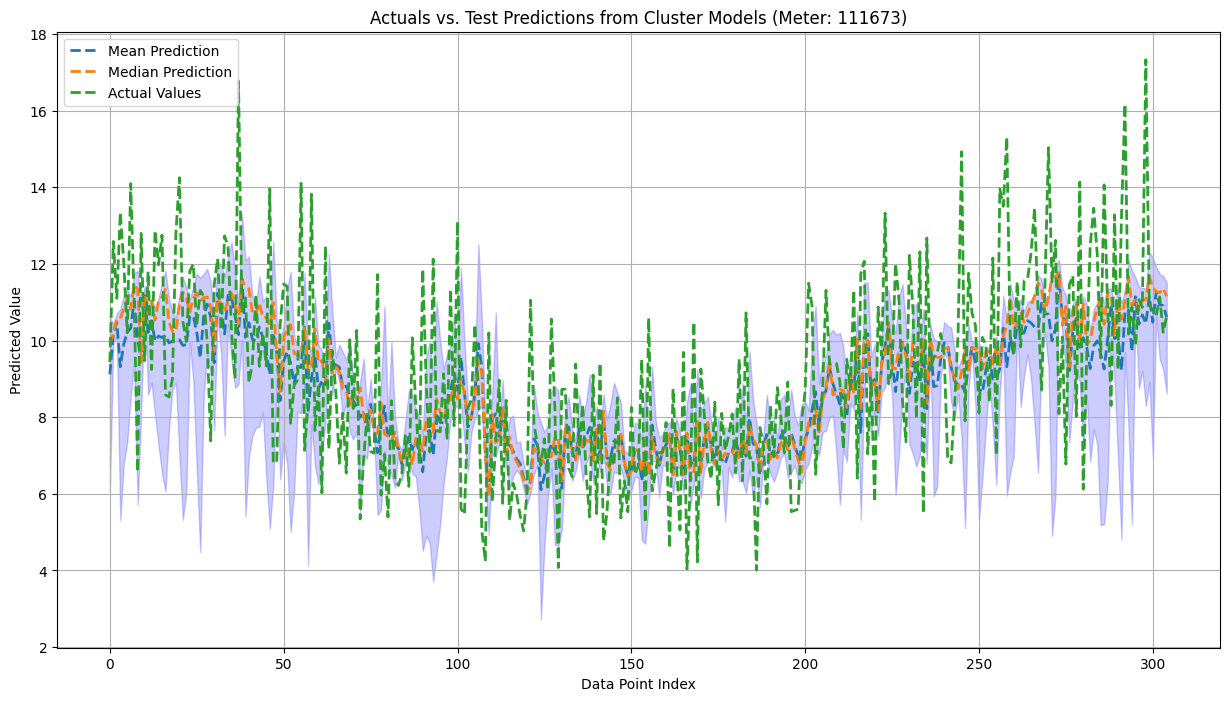

10/10 [==============================] - 0s 17ms/step
Results of meter:-  121305
Mean_Predictions
MAE: 1.3169841335109023
MAPE: 19.28098389920993
RMSE: 1.7145439755539396
 
Median_Predictions
MAE: 1.29435953206547
MAPE: 18.7030192808389
RMSE: 1.702017802315017


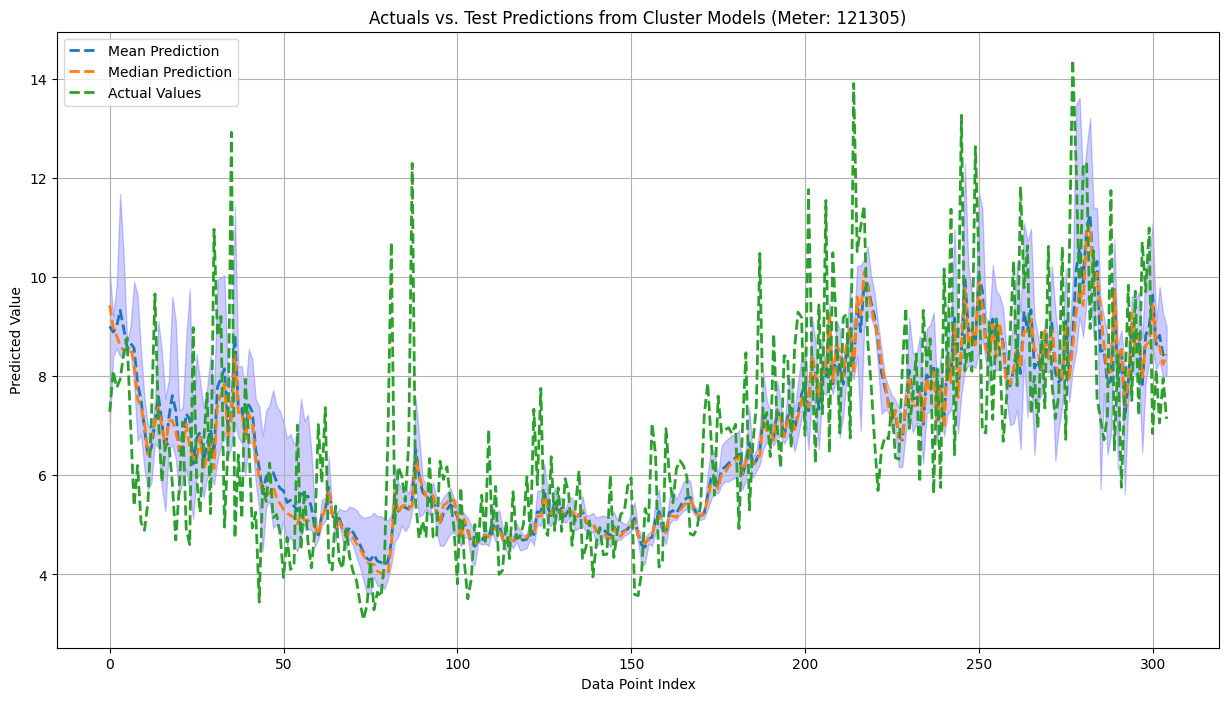

10/10 [==============================] - 0s 16ms/step
Results of meter:-  147313
Mean_Predictions
MAE: 1.9631267322978034
MAPE: 14.219219087143204
RMSE: 2.646602286197539
 
Median_Predictions
MAE: 1.929123165493324
MAPE: 13.813807643571163
RMSE: 2.61534176864477


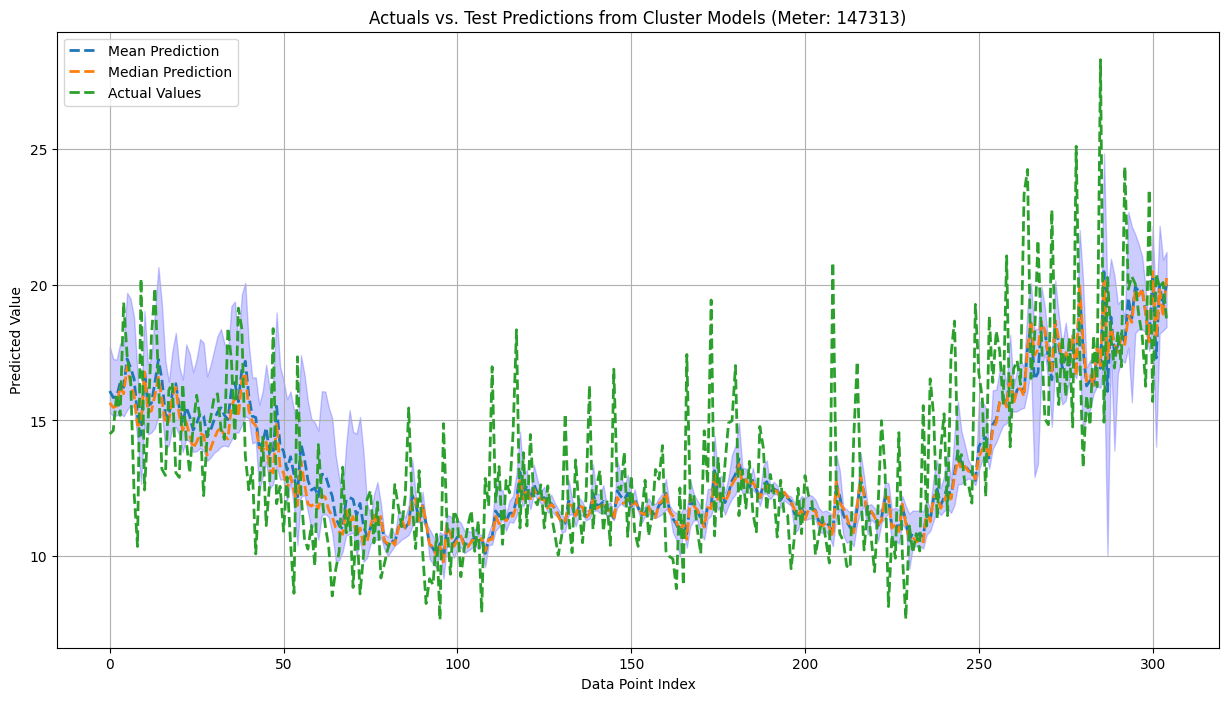

10/10 [==============================] - 0s 16ms/step
Results of meter:-  147622
Mean_Predictions
MAE: 7.715623259747614
MAPE: 121.99706534533732
RMSE: 10.740659118453225
 
Median_Predictions
MAE: 7.292482133596453
MAPE: 109.05662595207292
RMSE: 10.22089873338395


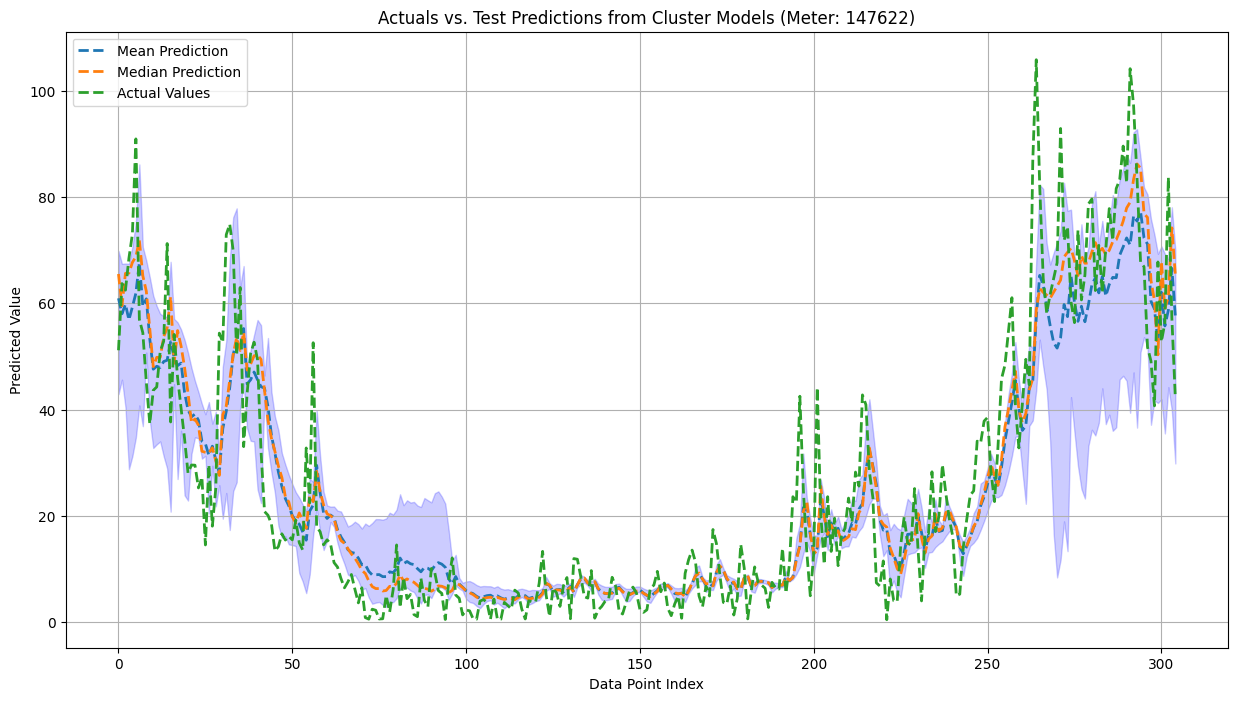

10/10 [==============================] - 0s 16ms/step
Results of meter:-  52529
Mean_Predictions
MAE: 0.5225684257694931
MAPE: 17.66154922635626
RMSE: 0.6768303358957448
 
Median_Predictions
MAE: 0.51510510380229
MAPE: 17.1803998258112
RMSE: 0.6721259238555995


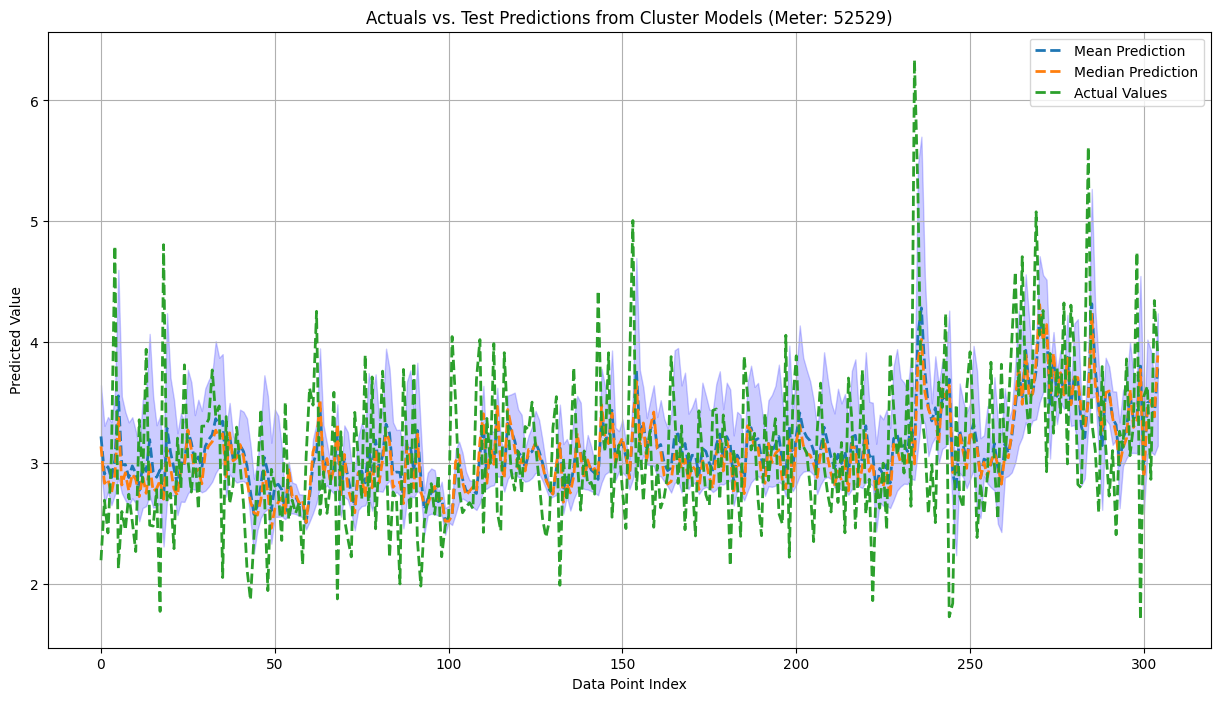

10/10 [==============================] - 0s 15ms/step
Results of meter:-  57041
Mean_Predictions
MAE: 0.958454518290035
MAPE: 15.12945967778499
RMSE: 1.3474752755527368
 
Median_Predictions
MAE: 0.9480232948053077
MAPE: 14.866219444812906
RMSE: 1.329011195381135


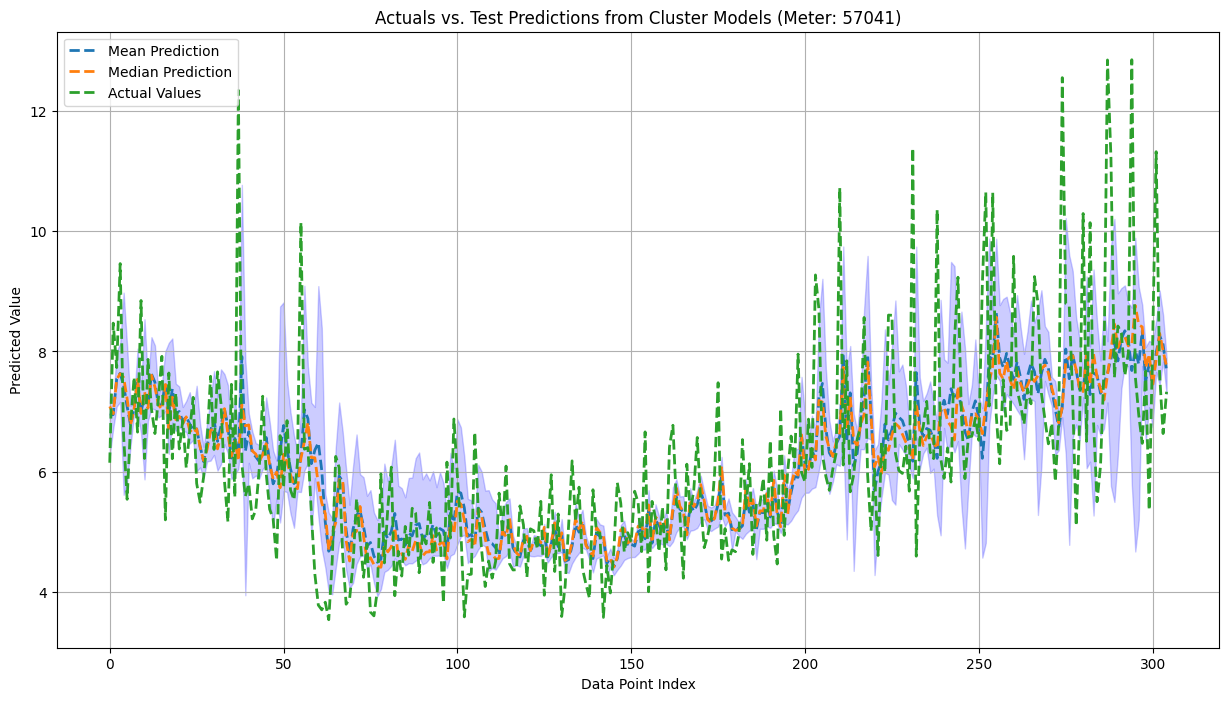

10/10 [==============================] - 0s 17ms/step
Results of meter:-  64409
Mean_Predictions
MAE: 1.0047214664084012
MAPE: 18.81761113260101
RMSE: 1.3888192789631044
 
Median_Predictions
MAE: 0.9906075564712775
MAPE: 18.78742819660139
RMSE: 1.3541961259419417


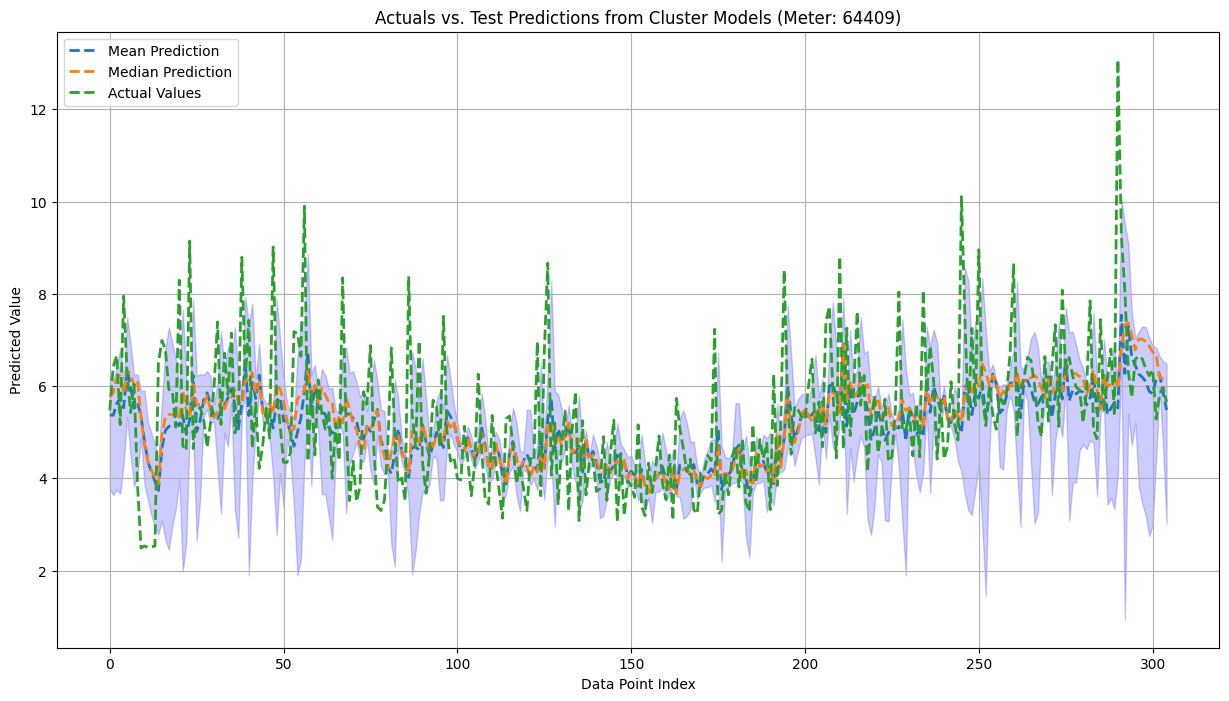

10/10 [==============================] - 0s 17ms/step
Results of meter:-  65353
Mean_Predictions
MAE: 1.8134478788532193
MAPE: 10.443462161901442
RMSE: 2.445073450931209
 
Median_Predictions
MAE: 1.781386770354724
MAPE: 10.175155231597904
RMSE: 2.4291588029161986


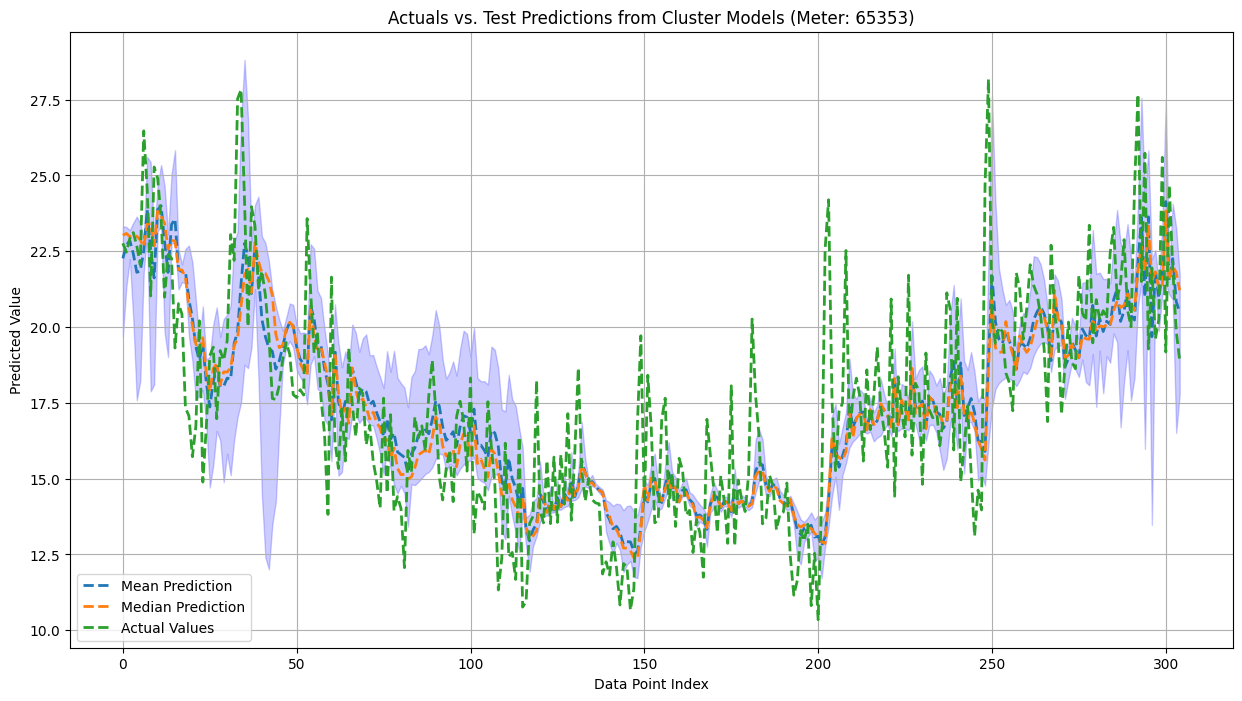

10/10 [==============================] - 0s 17ms/step
Results of meter:-  71137
Mean_Predictions
MAE: 0.8637519237330703
MAPE: 16.204572767005747
RMSE: 1.1078120233227764
 
Median_Predictions
MAE: 0.8456990617157983
MAPE: 15.847941727301981
RMSE: 1.09568040605891


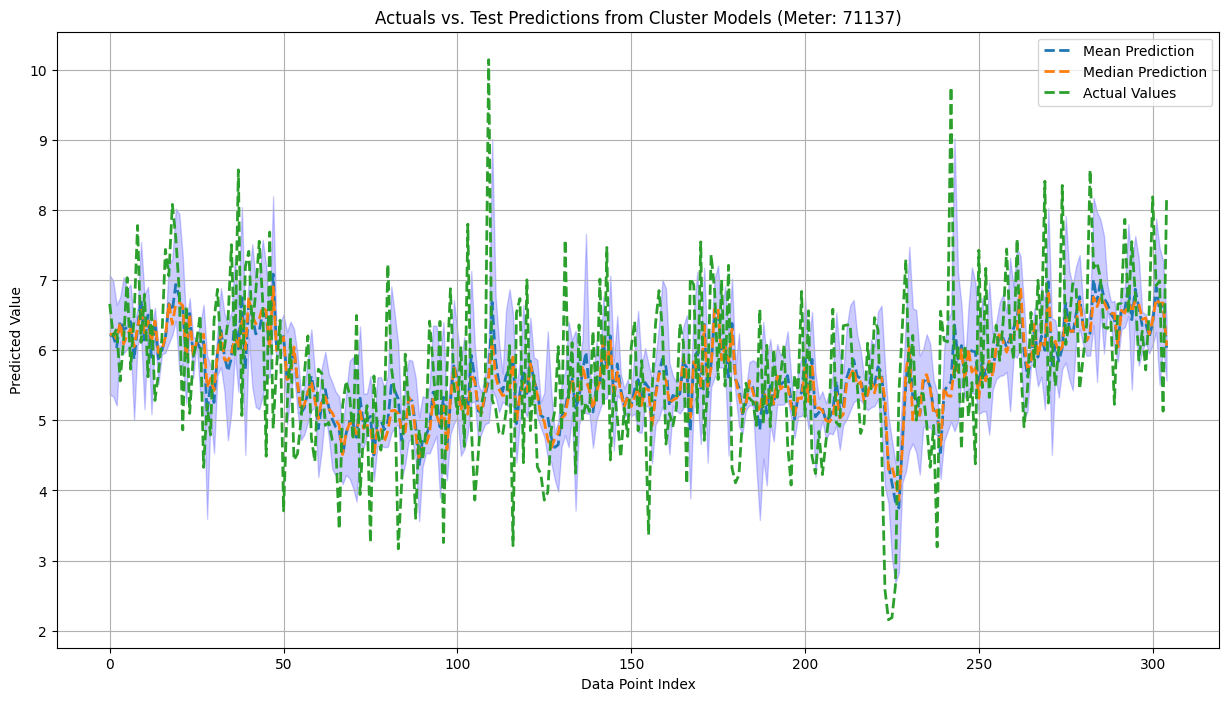

CSV file saved to E:\SMART GRID FOR EV\RESULTS\FINAL_RESULTS\Results_L1_30_timestep_60_20240504_120055.xlsx


In [56]:
# Individual meter data reading, predicting and exporting the results

M_folder_path = r'E:\SMART GRID FOR EV\SAME_METERS\TESTING_10'  # Specify the folder where your CSV files for meters consumption to predict are located

output_folder = r"E:\SMART GRID FOR EV\RESULTS\FINAL_RESULTS"   # Output foler path to save results

Results = []

for filename in os.listdir(M_folder_path):                   # Loop through the files in the folder
    if filename.endswith(".csv"):                           
        file_path = os.path.join(M_folder_path, filename)

        M_df_daily, M_Meter_number = excel_to_df(file_path)

        if M_df_daily is None:  
            continue                                         # Skip to the next CSV file

        M_dataset = M_df_daily

        M_X_train, M_X_test, M_X_val, M_y_train, M_y_test, M_y_val, M_train_univariate, M_val_univariate = data_splitting_shapping(M_dataset)

        base_prediction, median_prediction, min_prediction, max_prediction, predictions = base_model_predict(M_X_test)

        M_mae_test, M_mape_test, M_rmse_test, M_actual_test = model_eval(base_prediction, M_X_test, M_y_test)
    
        N_mae_test, N_mape_test, N_rmse_test, N_actual_test = model_eval(median_prediction, M_X_test, M_y_test)

        # Print the results
        print("=================================")
        print("Results of meter:- ",M_Meter_number)
        print("Mean_Predictions")
        print("MAE:", M_mae_test)
        print("MAPE:", M_mape_test)
        print("RMSE:", M_rmse_test)
        print(" ")
        print("Median_Predictions")
        print("MAE:", N_mae_test)
        print("MAPE:", N_mape_test)
        print("RMSE:", N_rmse_test)
        print("=================================")

        plot_graphs(M_Meter_number, M_dataset, M_actual_test, base_prediction, median_prediction, min_prediction, max_prediction, predictions)

        Results.append([M_Meter_number, M_mae_test, M_mape_test, M_rmse_test, N_mae_test, N_mape_test, N_rmse_test, time_step])

results_OP(Results, output_folder)

In [38]:
#  Base model function to combine all cluster-trained models

def base_model_predict(input_data):
    predictions = []
    for model in cluster_models:
        prediction = model.predict(input_data)
        predictions.append(prediction)
    # Averaging predictions from all cluster models 
    base_prediction = np.mean(predictions, axis=0)
    
    return base_prediction, predictions


def median(input_data):
    median_predictions = []
    for model in cluster_models:
        prediction = model.predict(input_data)
        median_predictions.append(prediction)
    # Averaging predictions from all cluster models 
    median_prediction = np.median(median_predictions, axis=0)    
    
    return median_prediction, median_predictions


In [40]:
# Individual meter data reading, predicting and exporting the results

M_folder_path = r'E:\SMART GRID FOR EV\SAME_METERS\TESTING_10'  # Specify the folder where your CSV files for meters consumption to predict are located

Results = []

for filename in os.listdir(M_folder_path):                   # Loop through the files in the folder
    if filename.endswith(".csv"):                           
        file_path = os.path.join(M_folder_path, filename)

        M_df_daily, M_Meter_number = excel_to_df(file_path)

        if M_df_daily is None:  
            continue                                         # Skip to the next CSV file

        M_dataset = M_df_daily

        M_X_train, M_X_test, M_X_val, M_y_train, M_y_test, M_y_val, M_train_univariate, M_val_univariate = data_splitting_shapping(M_dataset)

        base_prediction, predictions = base_model_predict(M_X_test)
        median_prediction, median_predictions = median(M_X_test)

        M_mae_test, M_mape_test, M_rmse_test, M_test_predictions, M_actual_test, M_mean_actual, M_raw_errors = model_eval(base_prediction, scaler, M_X_test, M_y_test)
    
        N_mae_test, N_mape_test, N_rmse_test, N_test_predictions, N_actual_test, N_mean_actual, N_raw_errors = model_eval(median_prediction, scaler, M_X_test, M_y_test)

        #plot_graphs(M_Meter_number,M_mae_test, M_mape_test, M_rmse_test, M_dataset, M_test_predictions, M_actual_test, M_raw_errors)

        #Results.append([M_Meter_number, M_mean_actual, M_mae_test, M_mape_test, M_rmse_test, time_step, EVALUATION_INTERVAL, EPOCHS, L1, LD1, Patience])

#results_OP(Results, output_folder)

10/10 [==============================] - 0s 14ms/step


In [41]:
base_prediction =scaler.inverse_transform(base_prediction)
median_prediction =scaler.inverse_transform(median_prediction)

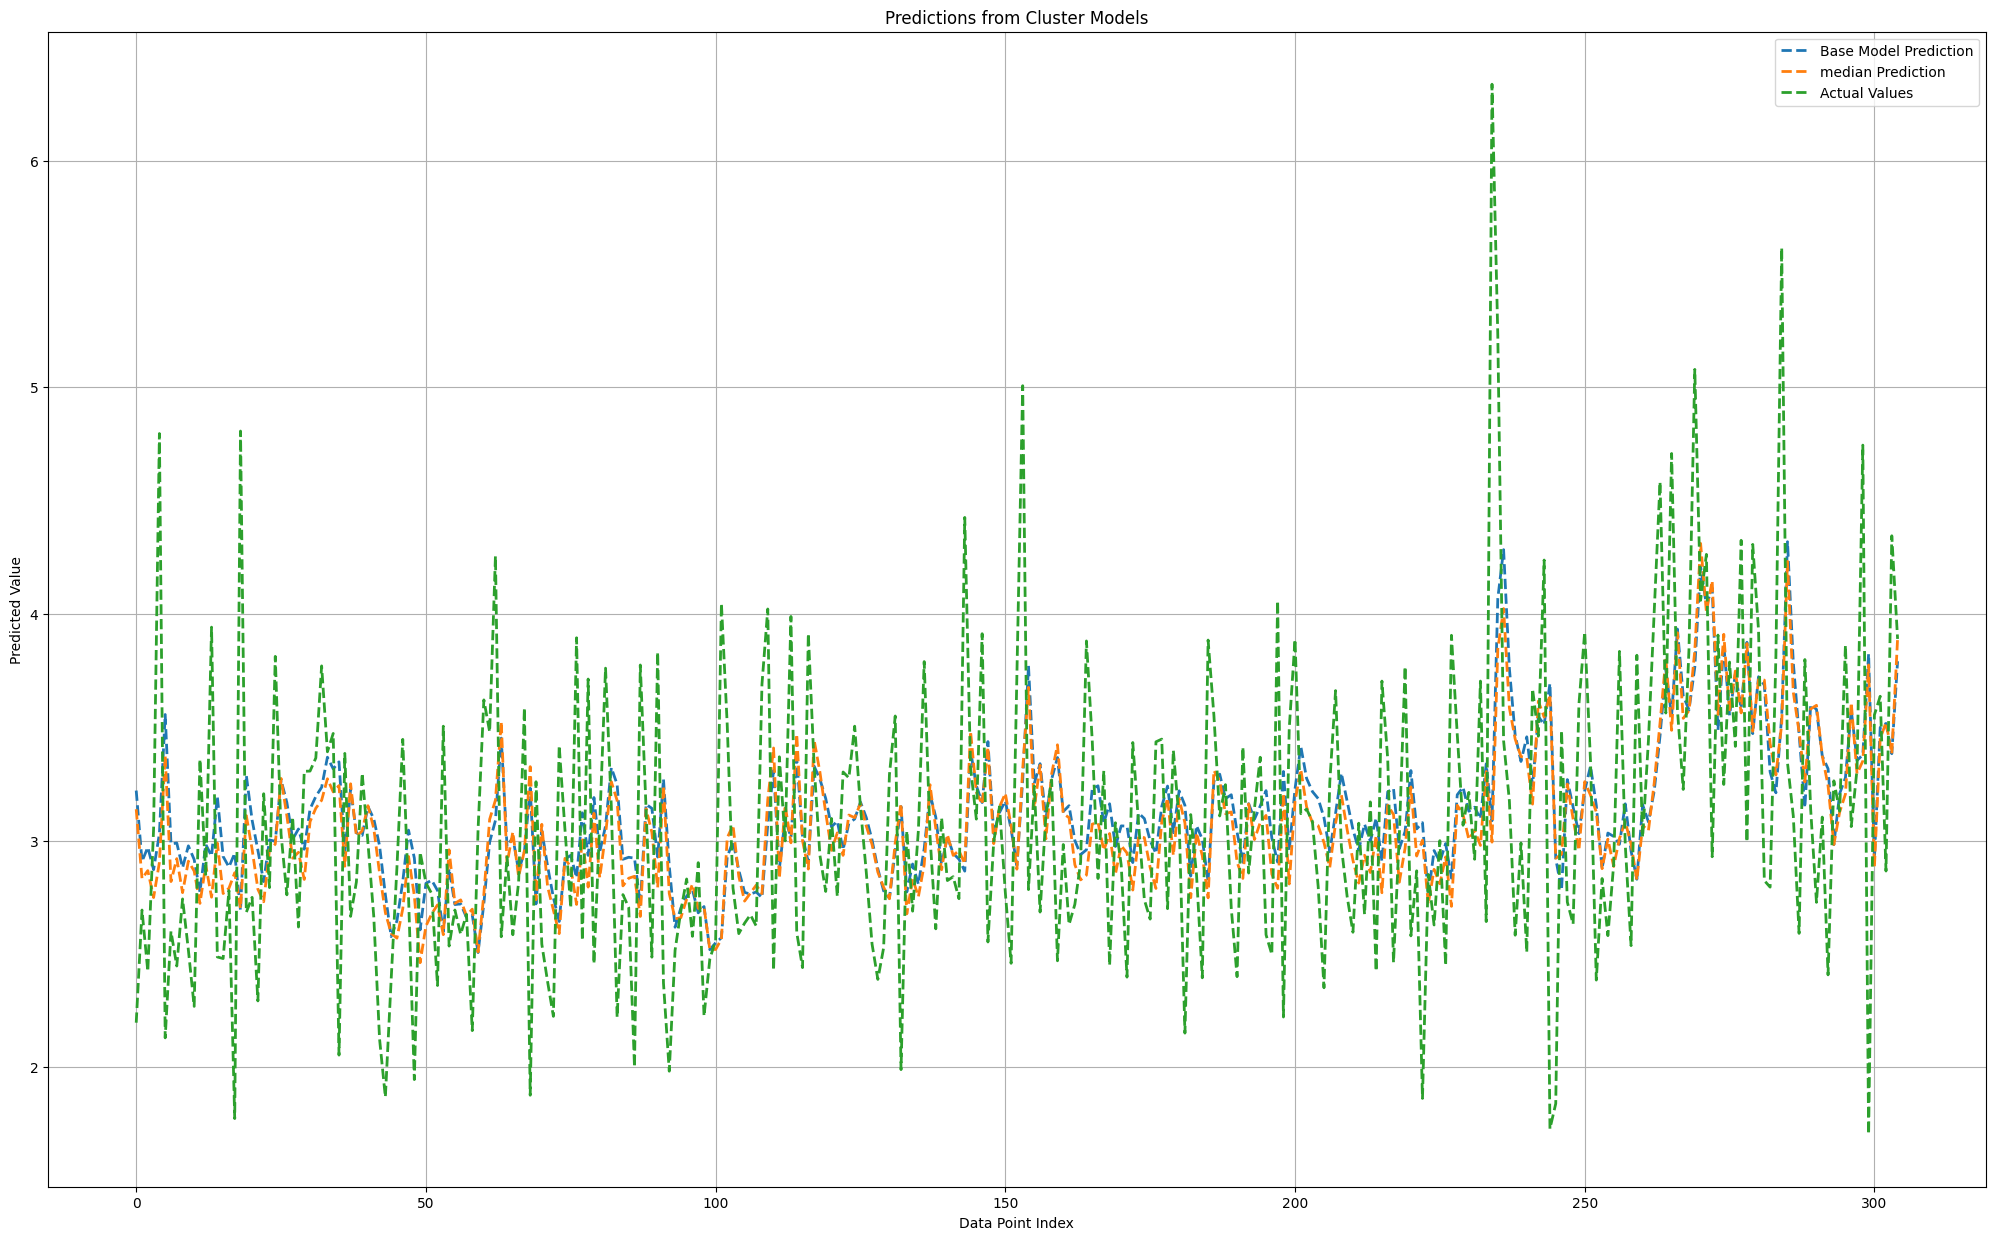

In [42]:
# Plotting

plt.figure(figsize=(25, 15))
#for i, prediction in enumerate(predictions):
    #prediction =scaler.inverse_transform(prediction)
    #plt.plot(prediction, label=f'Model {i+1} Prediction')

plt.plot(base_prediction, label='Base Model Prediction', linewidth=2, linestyle='--')
plt.plot(median_prediction, label='median Prediction', linewidth=2, linestyle='--')
plt.plot(M_actual_test, label='Actual Values', linewidth=2, linestyle='--')

plt.xlabel('Data Point Index')
plt.ylabel('Predicted Value')
plt.title('Predictions from Cluster Models')
plt.legend()
plt.grid(True)
plt.show()

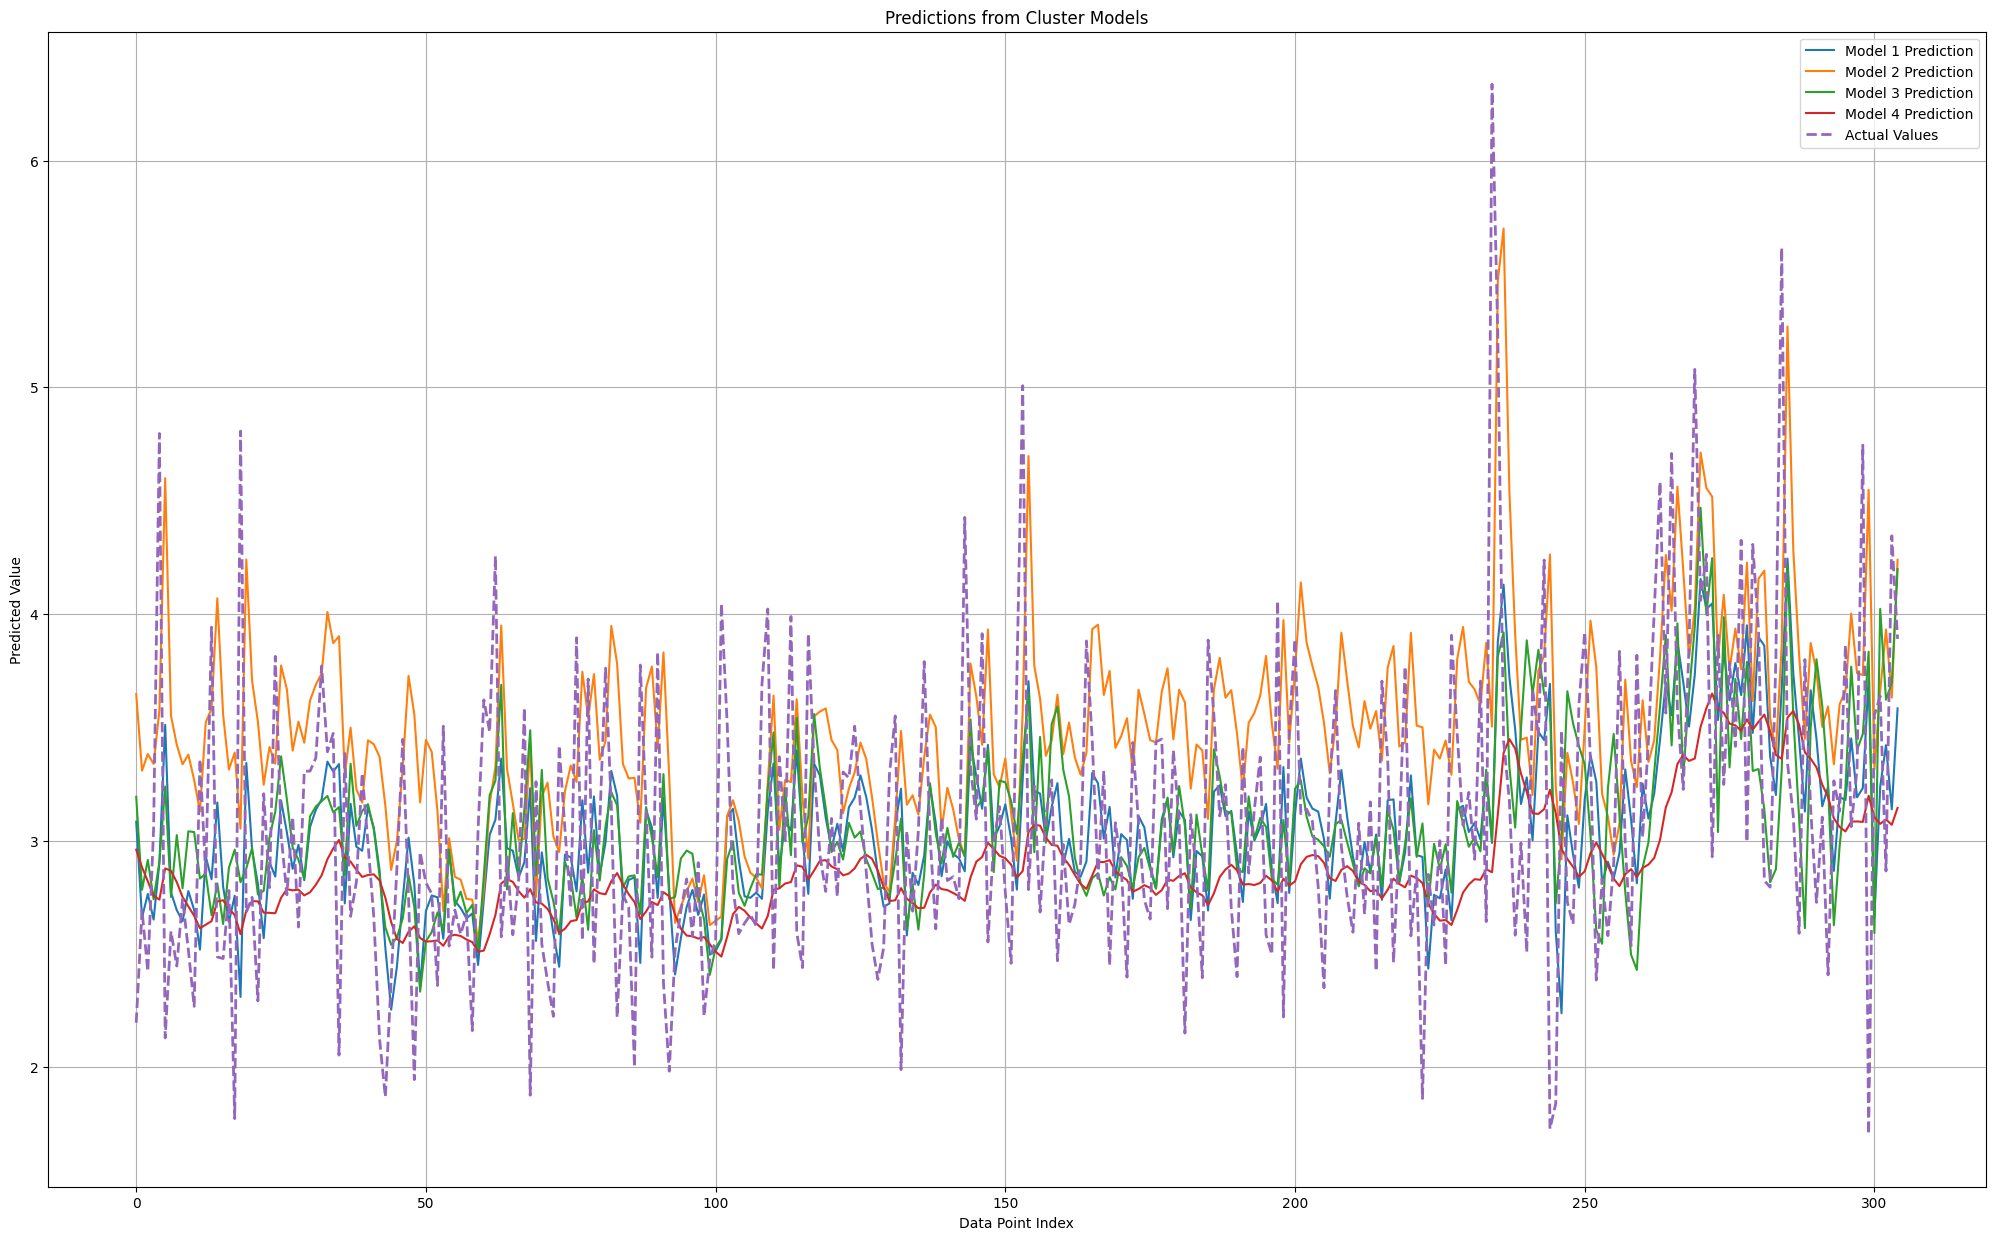

In [43]:
# Plotting

plt.figure(figsize=(25, 15))
for i, prediction in enumerate(predictions):
    prediction =scaler.inverse_transform(prediction)
    plt.plot(prediction, label=f'Model {i+1} Prediction')

#plt.plot(base_prediction, label='Base Model Prediction', linewidth=2, linestyle='--')
#plt.plot(median_prediction, label='median Prediction', linewidth=2, linestyle='--')
plt.plot(M_actual_test, label='Actual Values', linewidth=2, linestyle='--')

plt.xlabel('Data Point Index')
plt.ylabel('Predicted Value')
plt.title('Predictions from Cluster Models')
plt.legend()
plt.grid(True)
plt.show()

In [44]:

first_model = cluster_models[1]
    
# Predicting using the first model
first_prediction = first_model.predict(M_X_test)
    

10/10 [==============================] - 0s 19ms/step


In [45]:
f_mae_test, f_mape_test, f_rmse_test, f_test_predictions, f_actual_test, f_mean_actual, f_raw_errors = model_eval(first_prediction, scaler, M_X_test, M_y_test)


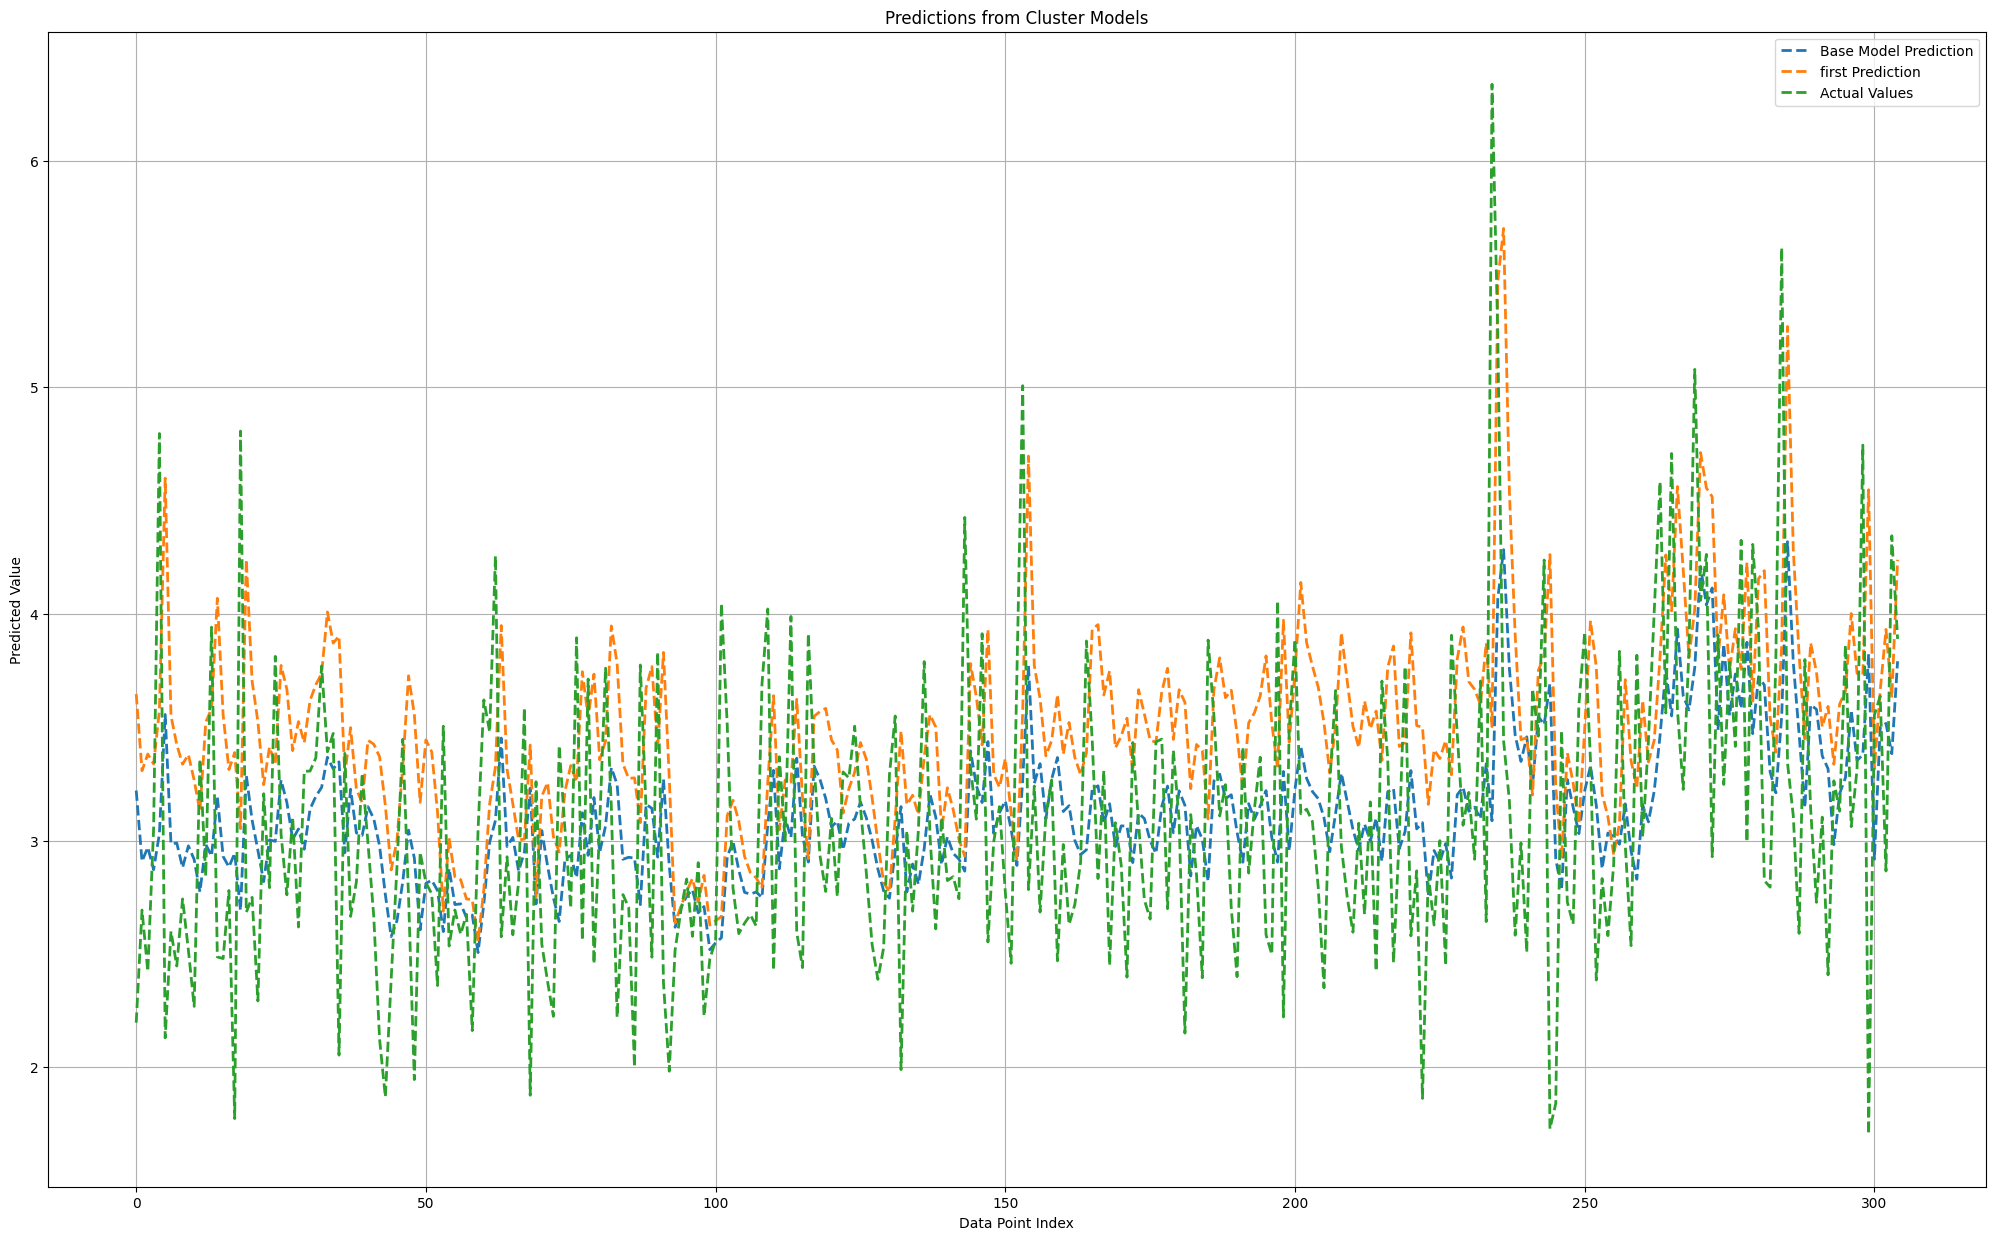

In [46]:
plt.figure(figsize=(25, 15))
#for i, prediction in enumerate(predictions):
    #prediction =scaler.inverse_transform(prediction)
    #plt.plot(prediction, label=f'Model {i+1} Prediction')

plt.plot(base_prediction, label='Base Model Prediction', linewidth=2, linestyle='--')
plt.plot(f_test_predictions, label='first Prediction', linewidth=2, linestyle='--')
plt.plot(M_actual_test, label='Actual Values', linewidth=2, linestyle='--')

plt.xlabel('Data Point Index')
plt.ylabel('Predicted Value')
plt.title('Predictions from Cluster Models')
plt.legend()
plt.grid(True)
plt.show()